In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from itertools import cycle, islice
import seaborn as sb
import matplotlib.dates as dates
import datetime as dt

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly import tools, subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

In [2]:
train_data = pd.read_csv("train.csv")#index_col=0
display(train_data.head())
test_data = pd.read_csv("test.csv")#index_col=0
display(test_data.head())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


In [3]:
train_data['NewConfirmedCases'] = train_data['ConfirmedCases'] - train_data['ConfirmedCases'].shift(1)
train_data['NewConfirmedCases'] = train_data['NewConfirmedCases'].fillna(0.0)
train_data['NewFatalities']     = train_data['Fatalities'] - train_data['Fatalities'].shift(1)
train_data['NewFatalities']     = train_data['NewFatalities'].fillna(0.0)#.astype(int)
train_data['MortalityRate']     = train_data['Fatalities'] / train_data['ConfirmedCases']
train_data['MortalityRate']     = train_data['MortalityRate'].fillna(0.0)
train_data['GrowthRate']        = train_data['NewConfirmedCases']/train_data['NewConfirmedCases'].shift(1)
train_data['GrowthRate']        = train_data['GrowthRate'].replace([-np.inf, np.inf],  0.0)
train_data['GrowthRate']        = train_data['GrowthRate'].fillna(0.0) 
display(train_data.head())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,NewConfirmedCases,NewFatalities,MortalityRate,GrowthRate
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def getColumnInfo(df):
    n_province =  df['Province_State'].nunique()
    n_country  =  df['Country_Region'].nunique()
    n_days     =  df['Date'].nunique()
    start_date =  df['Date'].unique()[0]
    end_date   =  df['Date'].unique()[-1]
    return n_province, n_country, n_days, start_date, end_date

n_train = train_data.shape[0]
n_test = test_data.shape[0]

n_prov_train, n_count_train, n_train_days, start_date_train, end_date_train = getColumnInfo(train_data)
n_prov_test,  n_count_test,  n_test_days,  start_date_test,  end_date_test  = getColumnInfo(test_data)

print ('<==Train data==> \n # of Province_State: '+str(n_prov_train),', # of Country_Region:'+str(n_count_train), 
       ', Time Period: '+str(start_date_train)+' to '+str(end_date_train), '==> days:',str(n_train_days))
print("\n Countries with Province/State information:  ", train_data[train_data['Province_State'].isna()==False]['Country_Region'].unique())
print ('\n <==Test  data==> \n # of Province_State: '+str(n_prov_test),', # of Country_Region:'+str(n_count_test),
       ', Time Period: '+start_date_test+' to '+end_date_test, '==> days:',n_test_days)

df_test = test_data.loc[test_data.Date > '2020-04-14']
overlap_days = n_test_days - df_test.Date.nunique()
print('\n overlap days with training data: ', overlap_days, ', total days: ', n_train_days+n_test_days-overlap_days)

<==Train data==> 
 # of Province_State: 133 , # of Country_Region:184 , Time Period: 2020-01-22 to 2020-05-15 ==> days: 115

 Countries with Province/State information:   ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']

 <==Test  data==> 
 # of Province_State: 133 , # of Country_Region:184 , Time Period: 2020-04-02 to 2020-05-14 ==> days: 43

 overlap days with training data:  13 , total days:  145


In [5]:
prob_confirm_check_train = train_data.ConfirmedCases.value_counts(normalize=True)
prob_fatal_check_train = train_data.Fatalities.value_counts(normalize=True)

n_confirm_train = train_data.ConfirmedCases.value_counts()[1:].sum()
n_fatal_train = train_data.Fatalities.value_counts()[1:].sum()

print('Percentage of confirmed case records = {0:<2.0f}/{1:<2.0f} = {2:<2.1f}%'.format(n_confirm_train, n_train, prob_confirm_check_train[1:].sum()*100))
print('Percentage of fatality records = {0:<2.0f}/{1:<2.0f} = {2:<2.1f}%'.format(n_fatal_train, n_train, prob_fatal_check_train[1:].sum()*100))

Percentage of confirmed case records = 23521/35995 = 65.3%
Percentage of fatality records = 15706/35995 = 43.6%


Trend by Country/Region for the maximum cases

In [6]:
train_data_by_country = train_data.groupby(['Date','Country_Region'],as_index=False).agg({'ConfirmedCases': 'sum', 'Fatalities': 'sum',
                                                                                         'GrowthRate':'last' })
#display(train_data_by_country.tail(10))
max_train_date = train_data['Date'].max()
train_data_by_country_confirm = train_data_by_country.query('(Date == @max_train_date) & (ConfirmedCases > 100)').sort_values('ConfirmedCases', ascending=False)
train_data_by_country_confirm.set_index('Country_Region', inplace=True)

train_data_by_country_confirm.style.background_gradient(cmap='Reds').format({'ConfirmedCases': "{:.0f}", 'GrowthRate': "{:.2f}"})

,Date,ConfirmedCases,Fatalities,GrowthRate
Country_Region,,,,
US,2020-05-15,1442653,87525.000000,1.15
Russia,2020-05-15,262843,2418.000000,1.06
United Kingdom,2020-05-15,238004,34078.000000,1.03
Spain,2020-05-15,230183,27459.000000,0.76
Italy,2020-05-15,223885,31610.000000,0.80
Brazil,2020-05-15,220291,14962.000000,1.31
France,2020-05-15,179630,27532.000000,0.83
Germany,2020-05-15,175233,7897.000000,1.99
Turkey,2020-05-15,146457,4055.000000,1.04


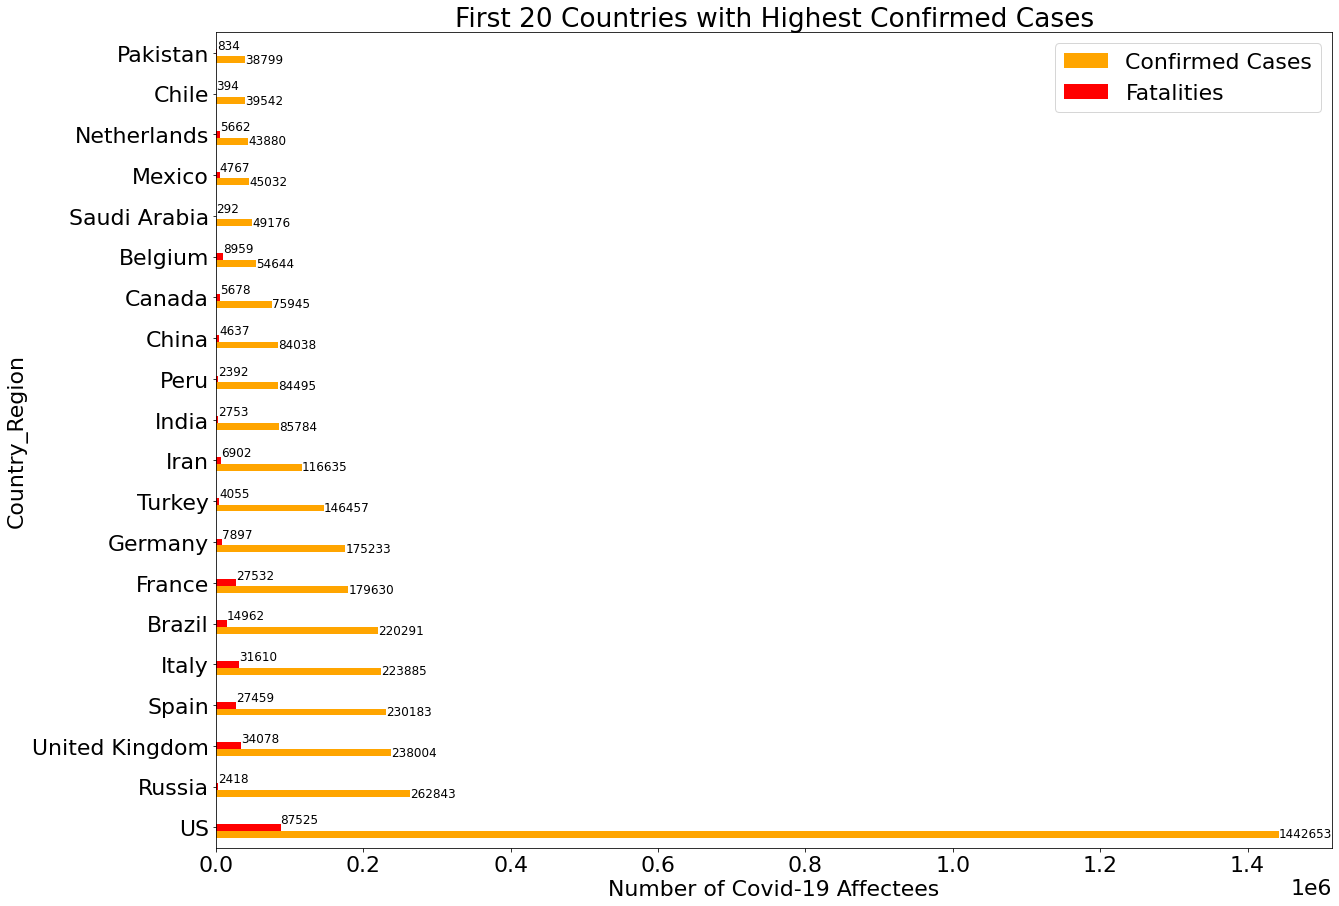

In [7]:
from itertools import cycle, islice
discrete_col = list(islice(cycle(['orange', 'r', 'g', 'k', 'b', 'c', 'm']), None, len(train_data_by_country_confirm.head(30))))
plt.rcParams.update({'font.size': 22})
train_data_by_country_confirm.head(20).plot(figsize=(20,15), kind='barh', color=discrete_col)
plt.legend(["Confirmed Cases", "Fatalities"]);
plt.xlabel("Number of Covid-19 Affectees")
plt.title("First 20 Countries with Highest Confirmed Cases")
ylocs, ylabs = plt.yticks()
for i, v in enumerate(train_data_by_country_confirm.head(20)["ConfirmedCases"][:]):
    plt.text(v+0.01, ylocs[i]-0.25, str(int(v)), fontsize=12)
for i, v in enumerate(train_data_by_country_confirm.head(20)["Fatalities"][:]):
    if v > 0: #disply for only >300 fatalities
        plt.text(v+0.01,ylocs[i]+0.1,str(int(v)),fontsize=12)  

Trend by Date

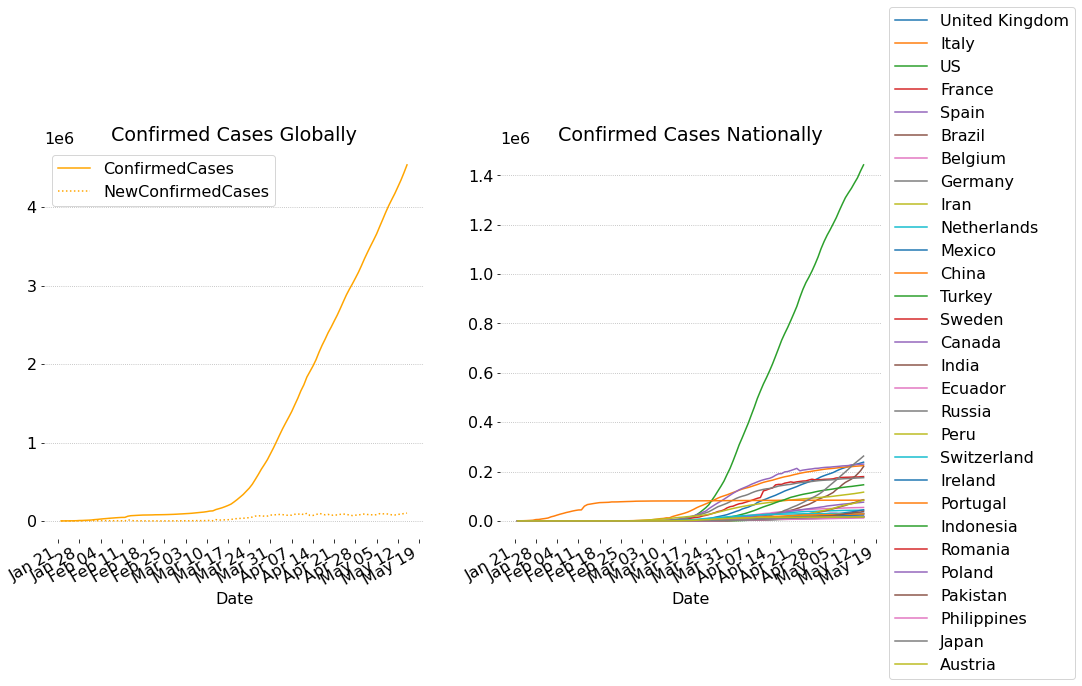

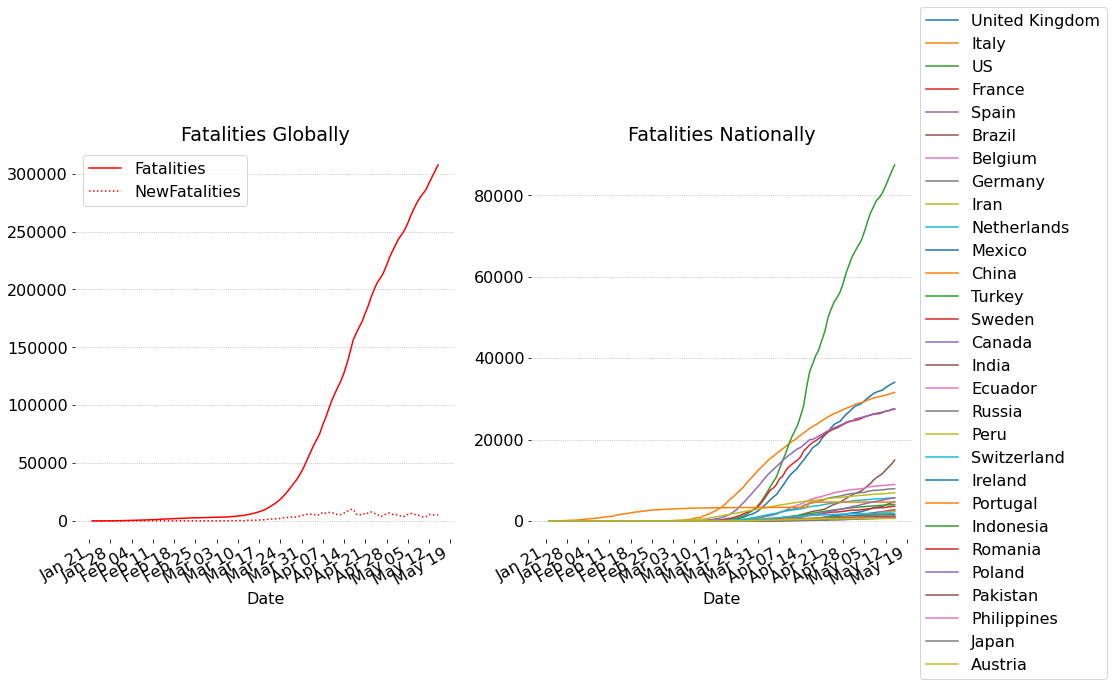

In [8]:
def reformat_time(reformat, ax):
    ax.xaxis.set_major_locator(dates.WeekdayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))    
    if reformat: #reformat again if you wish
        date_list = train_data_by_date.reset_index()["Date"].tolist()
        x_ticks = [dt.datetime.strftime(t,'%Y-%m-%d') for t in date_list]
        x_ticks = [tick for i,tick in enumerate(x_ticks) if i%8==0 ]# split labels into same number of ticks as by pandas
        ax.set_xticklabels(x_ticks, rotation=90)
    # cosmetics
    ax.yaxis.grid(linestyle='dotted')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data_by_date = train_data.groupby(['Date'],as_index=True).agg({'ConfirmedCases': 'sum','Fatalities': 'sum', 
                                                                     'NewConfirmedCases':'sum', 'NewFatalities':'sum', 'MortalityRate':'mean'})
num0 = train_data_by_date._get_numeric_data() 
num0[num0 < 0.0] = 0.0
#display(train_data_by_date.head())

## ======= Sort by countries with fatalities > 600 ========

train_data_by_country_max = train_data.groupby(['Country_Region'],as_index=True).agg({'ConfirmedCases': 'max', 'Fatalities': 'max'})
train_data_by_country_fatal = train_data_by_country_max[train_data_by_country_max['Fatalities']>600]
train_data_by_country_fatal = train_data_by_country_fatal.sort_values(by=['Fatalities'],ascending=False).reset_index()
#display(train_data_by_country_fatal.head(20))

df_merge_by_country = pd.merge(train_data,train_data_by_country_fatal['Country_Region'],on=['Country_Region'],how='inner')
df_max_fatality_country = df_merge_by_country.groupby(['Date','Country_Region'],as_index=False).agg({'ConfirmedCases': 'sum',
                                                                                                     'Fatalities': 'sum',
                                                                                                     'NewConfirmedCases':'sum',
                                                                                                     'NewFatalities':'sum',
                                                                                                     'MortalityRate':'mean'})

num1 = df_max_fatality_country._get_numeric_data() 
num1[num1 < 0.0] = 0.0
df_max_fatality_country.set_index('Date',inplace=True)
#display(df_max_fatality_country.head(20))

countries = train_data_by_country_fatal['Country_Region'].unique()

plt.rcParams.update({'font.size': 16})

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(15, 8))
fig,(ax2,ax3) = plt.subplots(1,2,figsize=(15, 8))#,sharey=True)

train_data_by_date.ConfirmedCases.plot(ax=ax0, x_compat=True, title='Confirmed Cases Globally', legend='Confirmed Cases',
                                       color=discrete_col)#, logy=True)
reformat_time(0,ax0)
train_data_by_date.NewConfirmedCases.plot(ax=ax0, x_compat=True, linestyle='dotted', legend='New Confirmed Cases',
                                          color=discrete_col)#, logy=True)
reformat_time(0,ax0)

train_data_by_date.Fatalities.plot(ax=ax2, x_compat=True, title='Fatalities Globally', legend='Fatalities', color='r')
reformat_time(0,ax2)
train_data_by_date.NewFatalities.plot(ax=ax2, x_compat=True, linestyle='dotted', legend='Daily Deaths',color='r')#tell pandas not to use its own datetime format
reformat_time(0,ax2)

for country in countries:
    match = df_max_fatality_country.Country_Region==country
    df_fatality_by_country = df_max_fatality_country[match] 
    df_fatality_by_country.ConfirmedCases.plot(ax=ax1, x_compat=True, title='Confirmed Cases Nationally')
    reformat_time(0,ax1)
    df_fatality_by_country.Fatalities.plot(ax=ax3, x_compat=True, title='Fatalities Nationally')
    reformat_time(0,ax3)
    
#ax1.legend(countries)
#ax3.legend(countries)
ax1.legend(countries, loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.legend(countries, loc='center left',bbox_to_anchor=(1.0, 0.5))

1. Confirmed Cases: It can be seen that a raise in maximum number of new cases appears in week of Feb 11-18, after which China reached its saturation point. Then a new sudden rise appears after March 24th, when the total new cases world wide crosses the total affectees in China alone.  
2. Deaths: As can be seen, since March 11th, the death toll rises steeply due to extreme rise in European countires, specially Italy, Spain, France and UK, and as well as now in US. The average mortality rate in these countries below can explain the peaks in the global mortality rate.

<Figure size 432x288 with 0 Axes>

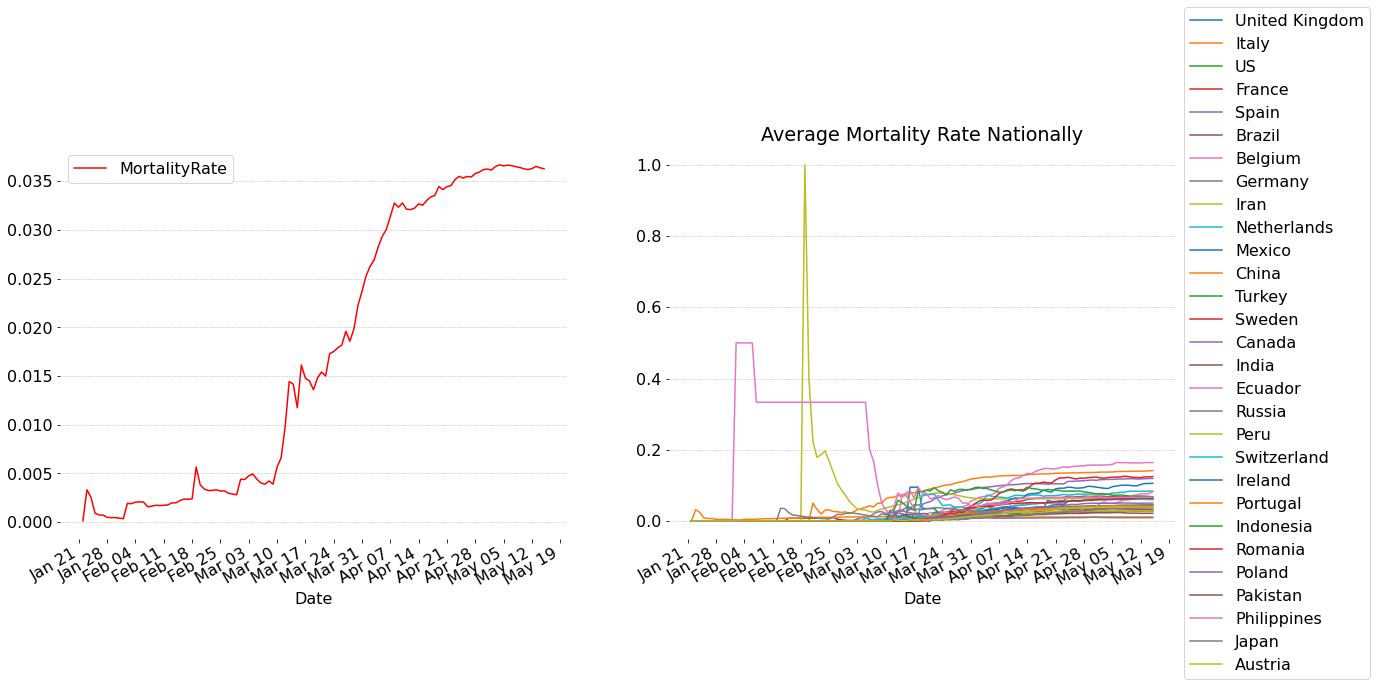

In [9]:
fig = plt.figure()
fig,(ax4,ax5) = plt.subplots(1,2,figsize=(20, 8))
#train_data_by_date.loc[(train_data_by_date.ConfirmedCases > 200)]#useless, its already summed.
train_data_by_date.MortalityRate.plot(ax=ax4, x_compat=True, legend='Mortality Rate',color='r')#tell pandas not to use its own datetime format
reformat_time(0,ax4)

for num, country in enumerate(countries):
    match = df_max_fatality_country.Country_Region==country 
    df_fatality_by_country = df_max_fatality_country[match] 
    df_fatality_by_country.MortalityRate.plot(ax=ax5, x_compat=True, title='Average Mortality Rate Nationally')    
    reformat_time(0,ax5)

ax5.legend(countries, loc='center left',bbox_to_anchor=(1.0, 0.5))

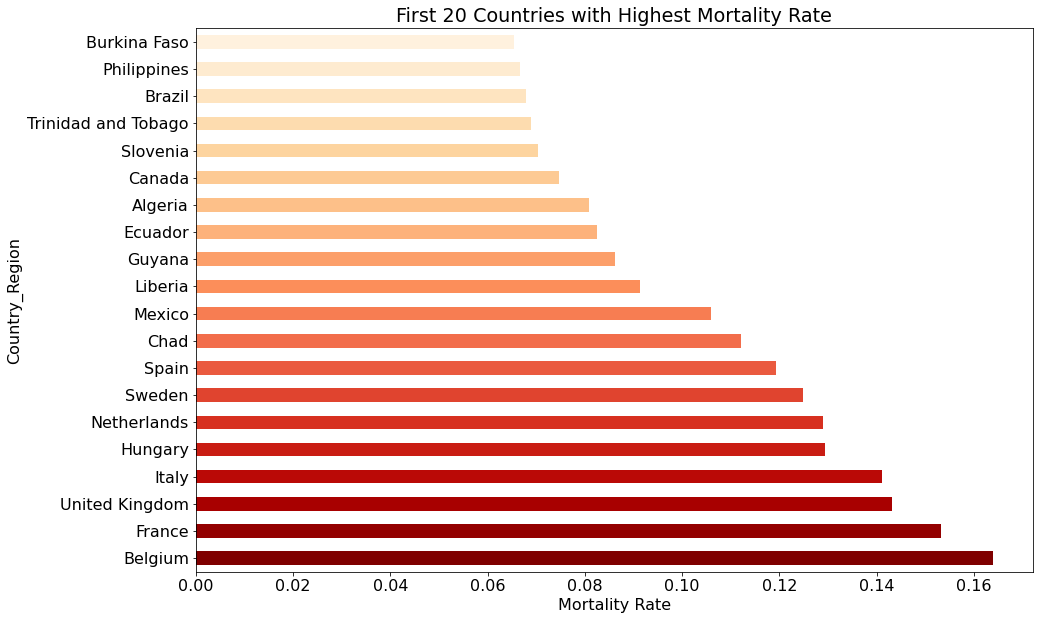

In [10]:
train_data_by_max_date = train_data_by_country.query('(Date == @max_train_date) & (ConfirmedCases > 100)')
train_data_by_max_date.loc[:, 'MortalityRate'] = train_data_by_max_date.loc[:,'Fatalities']/train_data_by_max_date.loc[:,'ConfirmedCases']
train_data_by_mortality = train_data_by_max_date.sort_values('MortalityRate', ascending=False)
train_data_by_mortality.set_index('Country_Region', inplace=True)
#display(train_data_by_mortality.head())

palette = plt.get_cmap('OrRd_r')
rainbow_col = [palette(1.*i/20.0) for i in range(20)]

train_data_by_mortality.MortalityRate.head(20).plot(figsize=(15,10), kind='barh', color=rainbow_col)
plt.xlabel("Mortality Rate")
plt.title("First 20 Countries with Highest Mortality Rate")
ylocs, ylabs = plt.yticks()

In [11]:
#import plotly.io as pio              # to set shahin plot layout

world_df = train_data_by_country.query('Date == @max_train_date')
world_df.loc[:,'Date']           = world_df.loc[:,'Date'].apply(str)
world_df.loc[:,'Confirmed_log']  = round(np.log10(world_df.loc[:,'ConfirmedCases'] + 1), 3)
world_df.loc[:,'Fatalities_log'] = np.log10(world_df.loc[:,'Fatalities'] + 1)
world_df.loc[:,'MortalityRate']  = round(world_df.loc[:, 'Fatalities'] / world_df.loc[:,'ConfirmedCases'], 3)
world_df.loc[:,'GrowthFactor']  = round(world_df.loc[:,'GrowthRate'], 3)
#display(world_df.head())

fig1 = px.choropleth(world_df, locations="Country_Region", 
                    locationmode="country names",  
                    color="Confirmed_log",                     
                    hover_name="Country_Region",
                    hover_data=['ConfirmedCases', 'Fatalities', 'MortalityRate', 'GrowthFactor'],
                    range_color=[world_df['Confirmed_log'].min(), world_df['Confirmed_log'].max()], 
                    color_continuous_scale = px.colors.sequential.Plasma,
                    title='COVID-19: Confirmed Cases')
fig1.show()